In [1]:
import sys
sys.path.append('../')

## Usage example of metrics for detection

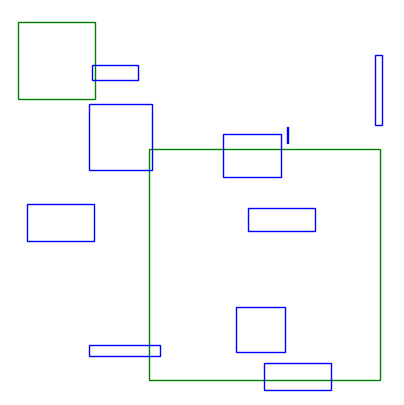

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from detection import PrecisionRecallF1Support
np.random.seed(42) # reproducibility

def xywh_to_xyxy(bbox, img_width=None, img_height=None):
    x, y, w, h = bbox
    if img_height and img_width:
        xyxy = [x * img_width, y * img_height, (x + w) * img_width, (y + h) * img_height]
    else:
        xyxy = [x, y, x + w, y + h]
    return xyxy

def random_box_generator(img_dims, max_h, max_w, n):
    img_height, img_width = img_dims
    boxes = []
    for i in range(n):
        x = np.random.randint(0, img_width)
        y = np.random.randint(0, img_height)
        w = np.random.randint(0, min(max_w, img_width - x))
        h = np.random.randint(0, min(max_h, img_height - y))
        boxes.append([x, y, w, h])
    return boxes

# create gt bboxes in xywh format
gt_bboxes = np.array([
    [180, 180, 300, 300],
    [10, 15, 100, 100],
])
gt_labels = np.array(["object"] * len(gt_bboxes))

# create pred bboxes in xywh format
pred_bboxes = random_box_generator((500, 500), 100, 100, 10)
pred_labels = np.array(["object"] * len(pred_bboxes))
pred_scores = np.array([1.0] * len(pred_bboxes))

# plot bboxes
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(np.ones((500, 500, 3)))
for i, bbox in enumerate(gt_bboxes):
    xy = bbox[:2]
    w, h = bbox[2:]
    ax.add_patch(plt.Rectangle(xy, w, h, fill=False, color="g"))
for i, bbox in enumerate(pred_bboxes):
    xy = bbox[:2]
    w, h = bbox[2:]
    ax.add_patch(plt.Rectangle(xy, w, h, fill=False, color="b"))
# hide axis
ax.axis("off")
plt.show()

In [3]:
from detection.utils import prepare_data_for_det_metrics

target, preds = prepare_data_for_det_metrics(
    [gt_bboxes, gt_bboxes], [gt_labels, gt_labels],
    [pred_bboxes, pred_bboxes], [pred_labels, pred_labels], [pred_scores, pred_scores]
)

print(f"{target=}\n{preds=}")

target=[{'boxes': tensor([[180, 180, 480, 480],
        [ 10,  15, 110, 115]]), 'labels': tensor([0, 0])}, {'boxes': tensor([[180, 180, 480, 480],
        [ 10,  15, 110, 115]]), 'labels': tensor([0, 0])}]
preds=[{'boxes': tensor([[102, 435, 194, 449],
        [106,  71, 166,  91],
        [102, 121, 184, 207],
        [330, 458, 417, 493],
        [359, 151, 361, 172],
        [308, 257, 395, 286],
        [293, 385, 356, 444],
        [276, 160, 351, 217],
        [ 21, 252, 109, 300],
        [474,  58, 483, 149]]), 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'scores': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)}, {'boxes': tensor([[102, 435, 194, 449],
        [106,  71, 166,  91],
        [102, 121, 184, 207],
        [330, 458, 417, 493],
        [359, 151, 361, 172],
        [308, 257, 395, 286],
        [293, 385, 356, 444],
        [276, 160, 351, 217],
        [ 21, 252, 109, 300],
        [474,  58, 483, 149]]), 'labels': tensor([0, 0, 0, 0, 0

In [4]:
area_ranges_tuples = [
    ("all", [0, 1e5 ** 2]),
    ("small", [0 ** 2, 6 ** 2]),
    ("medium", [6 ** 2, 12 ** 2]),  
    ("large", [12 ** 2, 1e5 ** 2])
]
area_ranges = [v for k, v in area_ranges_tuples]
area_ranges_labels = [k for k, v in area_ranges_tuples]

metric = PrecisionRecallF1Support(
    iou_thresholds=[1e-10],
    area_ranges=area_ranges,
    area_ranges_labels=area_ranges_labels,
)
metric.update(preds, target)
results = metric.compute();

                                             METRIC     tp,     fp,     fn,    dup,    pr,    re,    f1,   supp,    fpi,  nImgs
@[ IoU=0.00      | area=      all | maxDets=100 ] =      4,     16,      0,     10,  0.20,  1.00,  0.33,      4,      0,      2
@[ IoU=0.00      | area=    small | maxDets=100 ] =     -1,     -1,     -1,     -1, -1.00, -1.00, -1.00,      0,      0,      2
@[ IoU=0.00      | area=   medium | maxDets=100 ] =      0,      2,      0,      0,  0.00,  0.00,  0.00,      0,      2,      2
@[ IoU=0.00      | area=    large | maxDets=100 ] =      4,     14,      0,     10,  0.22,  1.00,  0.36,      4,      0,      2


In [5]:
print(f"{results.keys()=}")
for item in results['metrics'].items():
  print(item)

results.keys()=dict_keys(['params', 'eval', 'metrics'])
('all', {'range': [0, 10000000000.0], 'iouThr': '0.00', 'maxDets': 100, 'tp': 4, 'fp': 16, 'fn': 0, 'duplicates': 10, 'precision': 0.2, 'recall': 1.0, 'f1': 0.33333333333333337, 'support': 4, 'fpi': 0, 'nImgs': 2})
('small', {'range': [0, 36], 'iouThr': '0.00', 'maxDets': 100, 'tp': -1, 'fp': -1, 'fn': -1, 'duplicates': -1, 'precision': -1, 'recall': -1, 'f1': -1, 'support': 0, 'fpi': 0, 'nImgs': 2})
('medium', {'range': [36, 144], 'iouThr': '0.00', 'maxDets': 100, 'tp': 0, 'fp': 2, 'fn': 0, 'duplicates': 0, 'precision': 0.0, 'recall': 0, 'f1': 0, 'support': 0, 'fpi': 2, 'nImgs': 2})
('large', {'range': [144, 10000000000.0], 'iouThr': '0.00', 'maxDets': 100, 'tp': 4, 'fp': 14, 'fn': 0, 'duplicates': 10, 'precision': 0.2222222222222222, 'recall': 1.0, 'f1': 0.3636363636363636, 'support': 4, 'fpi': 0, 'nImgs': 2})


## Usage with FiftyOne

In [6]:
import os
# connect to global DB instead of local one (adjust path accordingly)
#os.environ["FIFTYONE_CONFIG_PATH"] = os.path.expanduser('~') + "/.fiftyone/config.global_mongodb.json"

import fiftyone as fo
from fiftyone import ViewField as F
fo.list_datasets()

['RGB_train_2023-03-28',
 'SAILING_28_06_2023_IR',
 'SAILING_DATASET',
 'SAILING_DATASET_QA',
 'SENTRY_VIDEOS_DATASET_QA',
 'TRAIN_THERMAL_DATASET_2023_06']

In [7]:
dataset = fo.load_dataset("SENTRY_VIDEOS_DATASET_QA")

# modify at will
det_gt_field = "ground_truth_det"

models = [
    dict(name="03_10_2022_N_LN1_ep48_FT", conf_thr=0),
    dict(name="volcanic-sweep-3_02_2023_N_LN1_ep288", conf_thr=0),
    dict(name="yolov5n_T16-8_D2306-v0_9C", conf_thr=0.18),
]

In [8]:
from detection import PrecisionRecallF1Support
from detection.utils import compute_metrics

# define metric params
area_ranges_tuples = [
    ("all", [0, 1e5 ** 2]),
    # ignore anything smaller than 1.53x1.53 in wFoV (6x6 in nFoV + unwated noise)
    ("valid_n", [1.53 ** 2 + 1e-5, 1e5 ** 2]),
    # ignore anything smaller than 6x6 in wFoV (we loose 6x6 --> 18x18 in nFoV)
    ("valid_w", [6 ** 2 + 1e-5, 1e5 ** 2]),
    ("tiny", [0, 1.53 ** 2]),
    ("small", [1.53 ** 2, 6 ** 2]),
    ("medium", [6 ** 2, 12 ** 2]),
    ("large", [12 ** 2, 1e5 ** 2])
]
area_ranges = [v for k, v in area_ranges_tuples]
area_ranges_labels = [k for k, v in area_ranges_tuples]

metric_params = dict(
    iou_thresholds=[1e-10],
    area_ranges=area_ranges,
    area_ranges_labels=area_ranges_labels,
    class_agnostic=True,
)

In [9]:
for model in models:
    print(f"##### {model['name']} #####")
    sentry_cnn_wFoV_results = compute_metrics(
        view=(
            dataset
            .select_group_slices(["thermal_wide", "thermal_narrow"])
            .filter_labels(f"frames.{model['name']}", F("confidence") >= model['conf_thr'], only_matches=False)
        ),
        gt_field=det_gt_field,
        pred_field=model['name'],
        metric_fn=PrecisionRecallF1Support,
        metric_kwargs=metric_params
    )
    print()

##### 03_10_2022_N_LN1_ep48_FT #####


Converting to metric format...
Computing metrics...
